# BRKGA Playground

## Set-up

In [46]:
from BRKGA import MST_BRKGA, ST_BRKGA, Greedy_BRKGA
from BRKGA.utils import generate_dissimilarity_matrix, compute_P_names
from BRKGA.plot import draw_partition_map
import igraph
import geopandas as gpd

In [47]:
# Define instance
id_state = "21"
num_regions = 4
# Reproducibility
seed = 123

In [48]:
# Read instance
path_graphs = "./Data/Mexican States/Graph Instances/"
with open(path_graphs + f"{id_state}.pkl", "rb") as f:
    graph = igraph.Graph.Read_Pickle(f)
print(f"State with ID: {id_state}")
print(f"Instance with {graph.vcount()} nodes")
print(f"Regionalization in {num_regions} regions\n")

State with ID: 21
Instance with 217 nodes
Regionalization in 4 regions



In [49]:
# Compute dissimilarity matrix
diss_matrix = generate_dissimilarity_matrix(graph)

In [50]:
# Read the gpkg file (for visualization)
path_gpkgs = "./Data/Mexican States/GPKG Instances/"
gdf_file: gpd.GeoDataFrame = gpd.read_file(path_gpkgs + f"{id_state}.gpkg")
palette_name = "husl"

## Apply BRKGA

In [51]:
# BRKGA parameters
config = {
    "population_size": 500,
    "elite_fraction": 0.2,
    "mutant_fraction": 0.2,
    "crossover_rate": 0.7,
    "max_generations": 1000,
    "tolerance_generations": 100,
    "max_time": 600,  
    "seed": seed
}

MST BRKGA

Best fitness: 19.397777
Execution time: 217.467717 seconds
Last generation: 199
Best solution found on iteration: 99


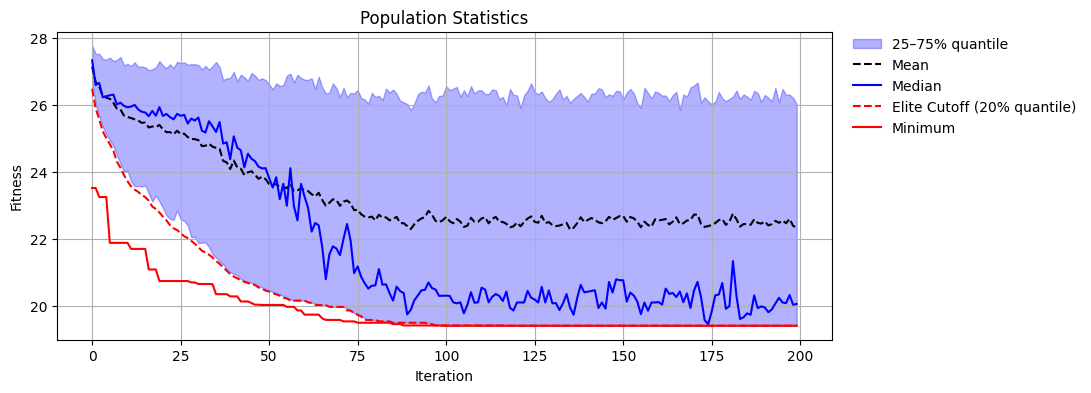

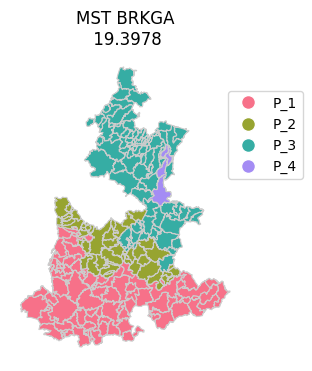

In [52]:
# Apply a MST BRKGA
print("MST BRKGA\n")
brkga = MST_BRKGA(graph, num_regions, diss_matrix, **config)
brkga.run()
brkga.print_statistics()
brkga.plot_evolution()
# Plot solution
f_P = brkga.evolution_stats["best_fitness"]
P_names = compute_P_names(graph, brkga.evolution_stats["best_solution"])
draw_partition_map(gdf_file, P_names, palette_name, title = f"MST BRKGA\n {f_P:.4f}")

ST BRKGA

Best fitness: 19.265897
Execution time: 208.896958 seconds
Last generation: 238
Best solution found on iteration: 138


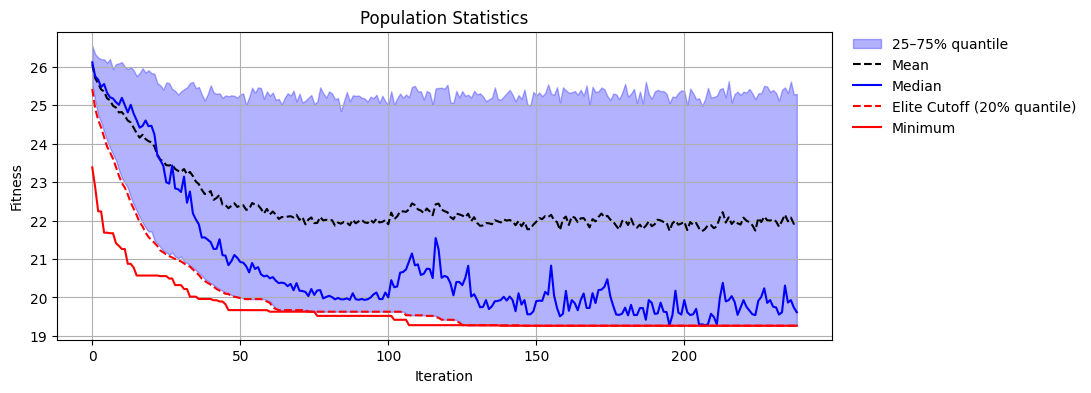

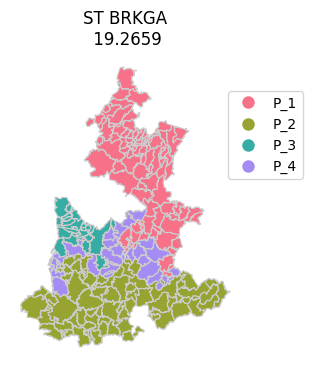

In [53]:
# Apply a ST BRKGA
print("ST BRKGA\n")
brkga = ST_BRKGA(graph, num_regions, diss_matrix ,**config)
brkga.run()
brkga.print_statistics()
brkga.plot_evolution()
# Plot solution
f_P = brkga.evolution_stats["best_fitness"]
P_names = compute_P_names(graph, brkga.evolution_stats["best_solution"])
draw_partition_map(gdf_file, P_names, palette_name, title = f"ST BRKGA\n {f_P:.4f}")

Greedy BRKGA

Best fitness: 18.727044
Execution time: 600.360783 seconds
Last generation: 117
Best solution found on iteration: 52


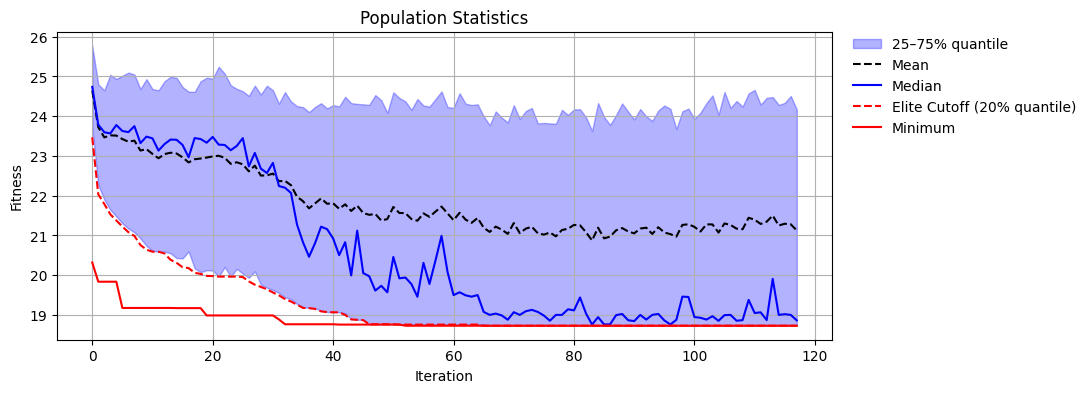

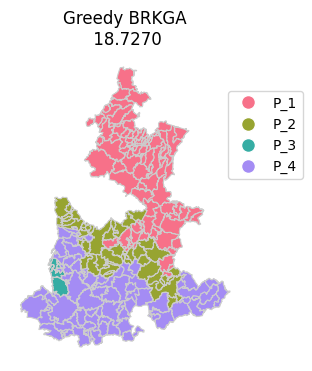

In [54]:
# Apply a Greedy BRKGA
print("Greedy BRKGA\n")
brkga = Greedy_BRKGA(graph, num_regions, diss_matrix, **config)
brkga.run()
brkga.print_statistics()
brkga.plot_evolution()
# Plot solution
f_P = brkga.evolution_stats["best_fitness"]
P_names = compute_P_names(graph, brkga.evolution_stats["best_solution"])
draw_partition_map(gdf_file, P_names, palette_name, title = f"Greedy BRKGA\n {f_P:.4f}")

## Compare with Pygeoda

In [55]:
from BRKGA.utils import igraph_to_gdf, labels_to_P, l2_objective_function_diss_matrix
import pygeoda
from typing import cast

In [56]:
# Obtain data compatible with pygeoda
created_gdf: gpd.GeoDataFrame = igraph_to_gdf(graph)
gda: pygeoda.gda.geodaGpd = cast(pygeoda.gda.geodaGpd, pygeoda.open(created_gdf))
w: pygeoda.Weight = pygeoda.queen_weights(gda)
data = gda[[field for field in gda.field_names if "x_" in field]]


In [57]:
# Chech that the data is correct
for v in graph.vs:
    # Attributes
    attributes_graph = v["x"]
    attributes_data = data.loc[v.index].values
    assert (attributes_data == attributes_graph).all()
    # Edges
    neighbors_graph = graph.neighbors(v.index)
    neighbors_w = w.gda_w.GetNeighbors(v.index)
    assert set(neighbors_graph) == set(neighbors_w)

SKATER



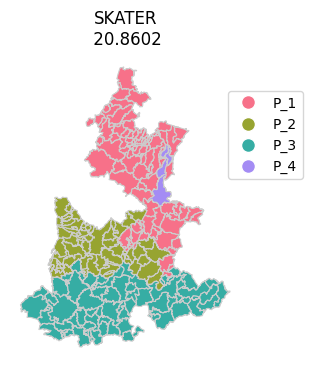

In [58]:
# Apply Skater
print("SKATER\n")
results = pygeoda.skater(num_regions, w, data,
                         distance_method='euclidean',
                         scale_method = "raw", 
                         random_seed = config["seed"] if config["seed"] else 0)

# Get final results
result_P = labels_to_P(results["Clusters"], num_regions)
f_P = l2_objective_function_diss_matrix(result_P, diss_matrix)
# Plot solution
P_names = compute_P_names(graph, result_P)
draw_partition_map(gdf_file, P_names, palette_name, title = f"SKATER\n {f_P:.4f}")

REDCAP



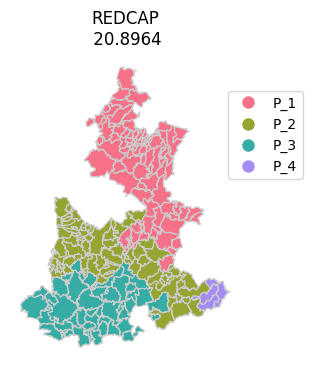

In [59]:
# Apply REDCAP
print("REDCAP\n")
results = pygeoda.redcap(num_regions, w, data,
                         method = "fullorder-averagelinkage",
                         distance_method='euclidean',
                         scale_method = "raw", 
                         random_seed = config["seed"] if config["seed"] else 0)

# Get final results
result_P = labels_to_P(results["Clusters"], num_regions)
f_P = l2_objective_function_diss_matrix(result_P, diss_matrix)
# Plot solution
P_names = compute_P_names(graph, result_P)
draw_partition_map(gdf_file, P_names, palette_name, title = f"REDCAP\n {f_P:.4f}")

SCHS



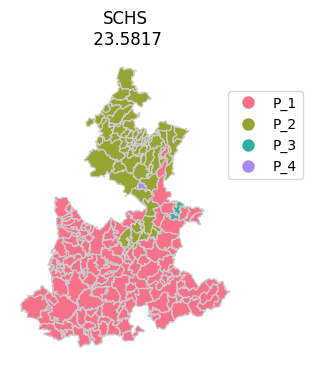

In [60]:
# Apply Skater
print("SCHS\n")
results = pygeoda.schc(num_regions, w, data,
                       linkage_method = "complete",
                       distance_method='euclidean',
                       scale_method = "raw", 
                       random_seed = config["seed"] if config["seed"] else 0)

# Get final results
result_P = labels_to_P(results["Clusters"], num_regions)
f_P = l2_objective_function_diss_matrix(result_P, diss_matrix)
# Plot solution
P_names = compute_P_names(graph, result_P)
draw_partition_map(gdf_file, P_names, palette_name, title = f"SCHS\n {f_P:.4f}")

AZP GREEDY



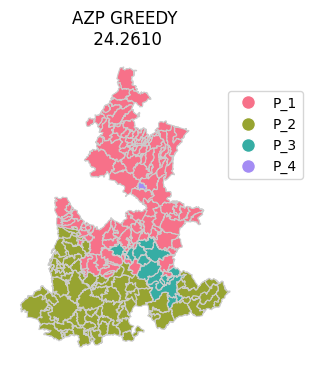

In [61]:
# Apply Skater
print("AZP GREEDY\n")
results = pygeoda.azp_greedy(num_regions, w, data,
                            distance_method='euclidean',
                            scale_method = "raw", 
                            random_seed = config["seed"] if config["seed"] else 0)

# Get final results
result_P = labels_to_P(results["Clusters"], num_regions)
f_P = l2_objective_function_diss_matrix(result_P, diss_matrix)
# Plot solution
P_names = compute_P_names(graph, result_P)
draw_partition_map(gdf_file, P_names, palette_name, title = f"AZP GREEDY\n {f_P:.4f}")

AZP SA



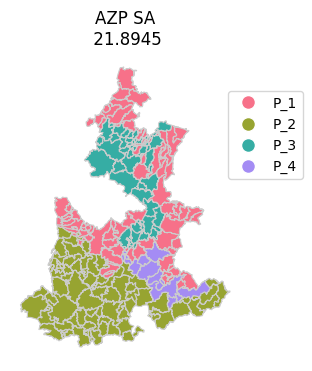

In [62]:
# Apply Skater
print("AZP SA\n")
results = pygeoda.azp_sa(num_regions, w, data,
                        distance_method='euclidean',
                        scale_method = "raw", 
                        random_seed = config["seed"] if config["seed"] else 0)

# Get final results
result_P = labels_to_P(results["Clusters"], num_regions)
f_P = l2_objective_function_diss_matrix(result_P, diss_matrix)
# Plot solution
P_names = compute_P_names(graph, result_P)
draw_partition_map(gdf_file, P_names, palette_name, title = f"AZP SA\n {f_P:.4f}")

AZP Tabu



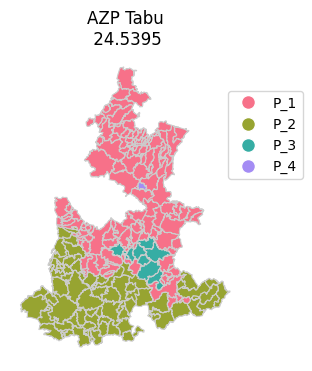

In [63]:
# Apply Skater
print("AZP Tabu\n")
results = pygeoda.azp_tabu(num_regions, w, data,
                           tabu_length = 10,
                            distance_method='euclidean',
                            scale_method = "raw", 
                            random_seed = config["seed"] if config["seed"] else 0)

# Get final results
result_P = labels_to_P(results["Clusters"], num_regions)
f_P = l2_objective_function_diss_matrix(result_P, diss_matrix)
# Plot solution
P_names = compute_P_names(graph, result_P)
draw_partition_map(gdf_file, P_names, palette_name, title = f"AZP Tabu\n {f_P:.4f}")